# Hub with Keras

[TensorFlow Hub](http://tensorflow.org/hub) is a way to share pretrained model components. See [their site](https://tfhub.dev/) for a searchable listing of pre-trained models.

This tutorial provides a quick walkthrough of how to use `tfhub` with `tf.keras`.

## Setup

### Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

tf.VERSION

'1.12.0'

### Dataset

 For this example we'll use the TensorFlow flowers dataset: 

In [27]:
import pathlib
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

data_root = pathlib.Path(data_root)
print(data_root)

/root/.keras/datasets/flower_photos


In [0]:
IMAGE_SIZE=224

The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`:

All of TensorFlow Hub's image modules expect input in the `[0, 1]`. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this. 

In [4]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(data_root, target_size=(IMAGE_SIZE, IMAGE_SIZE))

Found 3670 images belonging to 5 classes.


The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [28]:
for image_batch,label_batch in image_data:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(32, 224, 224, 3)
(32, 5)


## Build an ImageNet classifier

Use `hub.module` to load a mobilenet, and `tf.keras.layers.Lambda` to wrap it up as a keras layer.

In [0]:
mobilenet_layer = layers.Lambda(hub.Module("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2"))
mobilenet_classifier = tf.keras.Sequential([mobilenet_layer])

TensorFlow hub requires that you manually ititialize it's vairables. 

In [0]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

Now run the classifier on the image batch.

In [31]:
result_batch = mobilenet_classifier.predict(image_batch)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Fetch the `ImageNet` labels, and decode the predictions

In [35]:
import numpy as np
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
labels = np.array(open(labels_path).read().splitlines())

labels_batch = labels[np.argmax(result_batch, axis=-1)]
labels_batch

16384/10484 [==============================================] - 0s 0us/step


array(['pot', 'head cabbage', 'picket fence', 'daisy', 'daisy',
       'sea urchin', 'bell cote', 'daisy', 'picket fence', 'picket fence',
       'daisy', 'daisy', 'daisy', 'daisy', 'shower cap', 'coral fungus',
       "jack-o'-lantern", 'daisy', 'daisy', 'peacock', 'pot',
       'picket fence', 'wool', 'mushroom', 'daisy', 'grocery store',
       'cardoon', 'sea urchin', 'daisy', 'sea urchin', 'daisy', 'daisy'],
      dtype='<U30')

Now check how these predictions line up with the images:

See "/root/.keras/datasets/flower_photos/LICENSE.txt" for attributions.


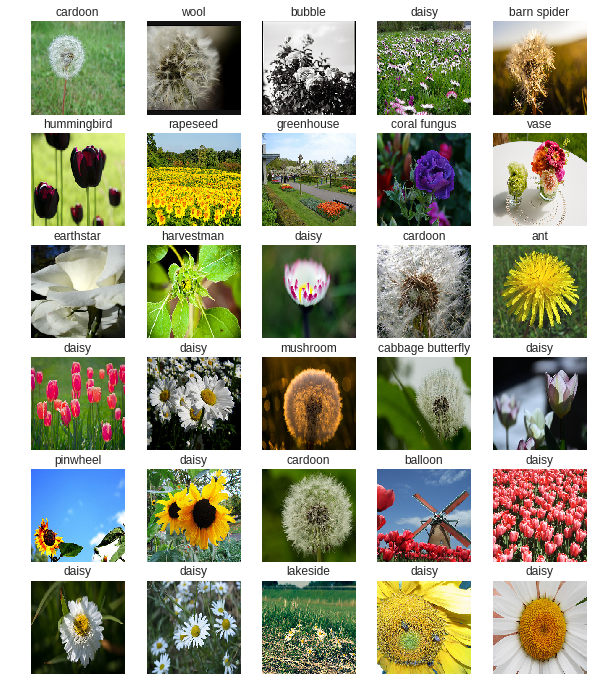

In [26]:
import matplotlib.pylab as plt

plt.figure(figsize=(10,12))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.grid(False)
  plt.axis('off')
print('See "{data_root}/LICENSE.txt" for attributions.'.format(data_root=data_root))

The results are far from perfect, but good considering that these are not the classes the model was trained for (except "daisy").

## Simple transfer learning

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

In [12]:
mobilenet_features_module = hub.Module("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2")
mobilenet_features = layers.Lambda(mobilenet_features_module)
mobilenet_features.trainable = False

INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'.
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'.


Again, this this must be initialized.

In [0]:
init = tf.global_variables_initializer()
sess.run(init)

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [0]:
model = tf.keras.Sequential([
  mobilenet_features,
  layers.Dense(image_data.num_classes, activation='softmax')
])

Test run a single batch, to see that the result comes back with the expected shape.

In [15]:
result = model.predict(image_batch)
result.shape

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


(32, 5)

Use compile to configure the training process:

In [0]:
model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy')

Now use the `.fit` method to train the model.

Normally you would set the number of steps per epoch, but to keep this example short we'll reain just long enough to see that the loss is reducing.

In [17]:
model.fit_generator(image_data, epochs=5, steps_per_epoch=10) #)steps_per_epoch=image_data.samples//image_data.batch_size)

Epoch 1/5
10/10 [==============================] - 6s 631ms/step - loss: 1.5109
Epoch 2/5
10/10 [==============================] - 1s 101ms/step - loss: 1.0235
Epoch 3/5
10/10 [==============================] - 1s 145ms/step - loss: 0.8229
Epoch 4/5
10/10 [==============================] - 2s 171ms/step - loss: 0.6832
Epoch 5/5
10/10 [==============================] - 2s 165ms/step - loss: 0.5622
